In [1]:
"""
    This cell contains libraries and functions necessary for the numerical methods used
    in this notebook and the display within this notebook
    """
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import display,Image, Latex
from __future__ import division
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc
import h5py

import sympy as sym


class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 16,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)


from scipy.sparse import csr_matrix
def nufd(x):
    n = len(x)
    h = x[1:]-x[:n-1]
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

# Reciprocal Channel Flow

A reciprocal channel flow is driven by an oscillatory pressure gradient yielding a net zero-massflow when averaged over one full period. For simplicity the flow is assumed incompressible and the governing equations are:
##### Continuity
$$ \partial_iu_i = 0$$  
##### Conservation of momentum:
$$ \partial_tu_i +u_j\partial_ju_i = \frac{1}{\rho}\partial_ip+\nu\partial_j\partial_ju_i+A\sin(\omega t)
$$
##### Heat equation
$$ \partial_t\theta+u_i\partial_i\theta = \alpha\partial_i\partial_i\theta
$$
The channel consists of two parallel, flat and smooth plates of very large dimensions compared to the channel height ($2h$). As such the flow may be assumed to vary only in time and in the direction perpendicular to the plates. The boundary conditions are:
##### No-slip 
$$
u_i(x_2=\pm h,t)=0
$$
#### Isothermal
$$
\theta(x_2=+h,t)=-1/2
$$

In [2]:
import numpy as np
def TDMAsolver(a, b, c, d):
    '''
    TDMA solver, a b c d can be NumPy array type or Python list type.
    refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    '''
    nf = len(a)     # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d))     # copy the array
    for it in range(1, nf):
        mc = ac[it]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]

    xc = ac
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    del bc, cc, dc  # delete variables from memory

    return xc

In [3]:
from scipy.optimize import fsolve
def find_gamma(ly,y_uni,dy_min,g_ini):
    def delta_tanh(g):
        return ly/2.0*np.tanh(g*(y_uni[1]))/np.tanh(g*ly/2.0)-(-ly/2+dy_min)
    g_dy_min = fsolve(delta_tanh,g_ini)
    return g_dy_min
def stretched_mesh(ly,ny,dy_min,g_ini):
    y_uni = np.linspace(-ly/2, ly/2, ny)
    gamma_y = find_gamma(ly,y_uni,dy_min,g_ini)
    y_s = ly/2.0*np.tanh(gamma_y*(y_uni))/np.tanh(gamma_y*ly/2.0)
    return y_s

In [4]:
from scipy.sparse import csr_matrix
def nufd(x):
    n = len(x)
    h = x[1:]-x[:n-1]
    a0 = -(2*h[0]+h[1])/(h[0]*(h[0]+h[1]))
    ak = -h[1:]/(h[:n-2]*(h[:n-2]+h[1:]))
    an = h[-1]/(h[-2]*(h[-1]+h[-2]))
    b0 = (h[0]+h[1])/(h[0]*h[1]) 
    bk = (h[1:] - h[:n-2])/(h[:n-2]*h[1:])
    bn = -(h[-1]+h[-2])/(h[-1]*h[-2])
    c0 = -h[0]/(h[1]*(h[0]+h[1]))
    ck = h[:n-2]/(h[1:]*(h[:n-2]+h[1:]))
    cn = (2*h[-1]+h[-2])/(h[-1]*(h[-2]+h[-1]))
    val  = np.hstack((a0,ak,an,b0,bk,bn,c0,ck,cn))
    row = np.tile(np.arange(n),3)
    dex = np.hstack((0,np.arange(n-2),n-3))
    col = np.hstack((dex,dex+1,dex+2))
    D = csr_matrix((val,(row,col)),shape=(n,n))
    return D

In [5]:
folder = "Pulsatile/T30/"
filenameh5 = "Stats-T30-128.03.h5"

hf = h5py.File(folder+filenameh5, 'r')
stats = hf['stats'][:]
z = hf['z'][:]
hf.close()
nz = 129

nx = 128
ny = 128
nz = 129
run = "03"
number_of_phases = 32 # over half a period
number_of_periods = 1


z_all = np.zeros(nz+2)
z_all[0] = -1.
z_all[-1] = 1.
z_all[1:-1] = np.copy(z)
a_metrics = np.zeros(nz)
c_metrics = np.zeros(nz)
a_metrics[:] = 1. / ((z_all[1:-1] - z_all[0:-2])*(z_all[2:]-z_all[0:-2]))
c_metrics[:] = 1. / ((z_all[2:] - z_all[1:-1])*(z_all[2:]-z_all[0:-2]))
dz = nufd(z_all)


nu = 1./2000
i_mean = 0
i_ms = 1
i_skew = 2
i_flat = 3
nstats = 4
i_u = 0
i_uu = 1
i_vv = 2
i_ww = 3
i_T = 4
i_uw = 5
i_wT = 6
i_dudy = 7
i_eps = 8
i_dTdy = 9
nscalars = 10


    


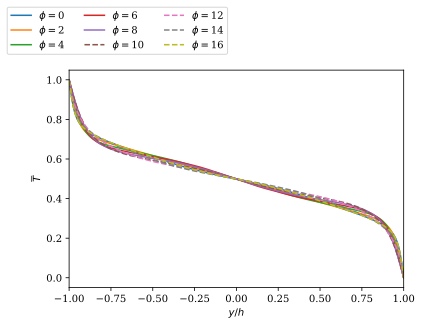

In [6]:
for iphase in range(number_of_phases//4+1):
    if iphase <= number_of_phases //8:
        plt.plot(z,stats[2*iphase,i_T,:], label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,stats[2*iphase,i_T,:], '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$\overline{T}$")
plt.savefig("MeanTemperature.pdf", bbox_inches="tight")
plt.show()

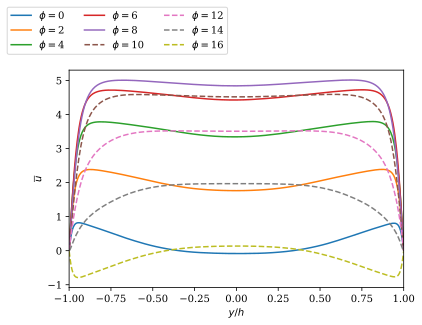

In [7]:
for iphase in range(number_of_phases//4+1):
    if iphase <= number_of_phases //8:
        plt.plot(z,stats[2*iphase,i_u,:], label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,stats[2*iphase,i_u,:], '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$\overline{u}$")
plt.savefig("MeanVelocity.pdf", bbox_inches="tight")
plt.show()

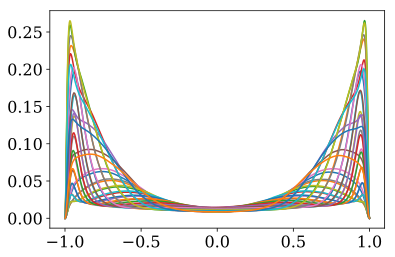

In [8]:
k_base = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[iphase,i,:]
    k /= 2.
    k_base[:,iphase] = np.copy(k)
    plt.plot(z,k)

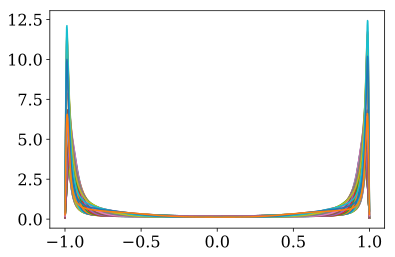

In [9]:
k_base = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[iphase,i,:]
    k /= 2.
    k_base[:,iphase] = np.copy(k)
    k = k**0.5*(1-stats[iphase,i_dTdy,:])**2
    
    plt.plot(z,k)

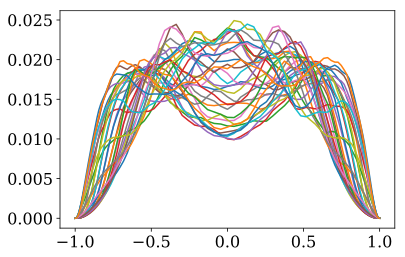

In [10]:
for iphase in range(number_of_phases):
    plt.plot(z,-stats[iphase,i_wT,:]/stats[iphase,i_dTdy])

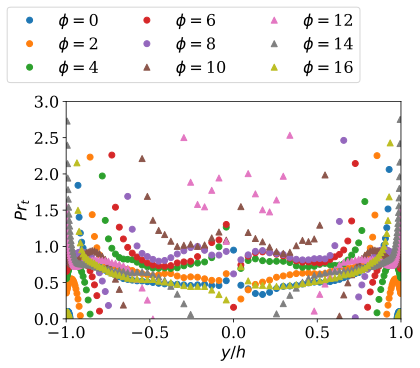

In [11]:
for iphase in range(number_of_phases//4+1):
    nu_t = -stats[2*iphase,i_uw,:]/stats[2*iphase,i_dudy]
    alpha_t = -stats[2*iphase,i_wT,:]/stats[2*iphase,i_dTdy]
    Prt = nu_t/alpha_t
    if iphase <= number_of_phases //8:
        plt.plot(z,Prt, 'o', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,Prt, '^', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
plt.ylim(0,3)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$Pr_t$")
plt.savefig("Prt_exact.pdf", bbox_inches="tight")
plt.show()


/Users/dubief/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


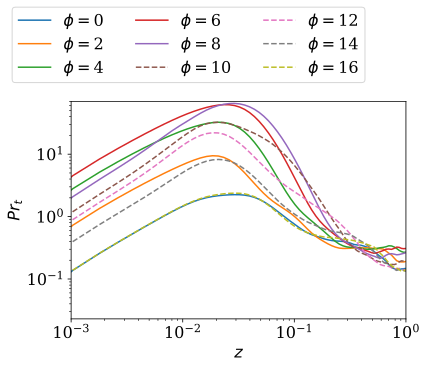

In [19]:
for iphase in range(number_of_phases//4+1):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[2*iphase,i,:]
    k /= 2.
    nu_t = 0.09*k**2/stats[2*iphase,i_eps,:]
    alpha_t = -stats[2*iphase,i_wT,:]/stats[2*iphase,i_dTdy,:]
    Prt = nu_t/alpha_t
    if iphase <= number_of_phases //8:
        plt.loglog(1+z,Prt, '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.loglog(1+z,Prt, '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(1e-3,1)
plt.ylim(0,70)
plt.xlabel(r"$z$")
plt.ylabel(r"$Pr_t$")
plt.savefig("Prt_k-e-loglog.png", bbox_inches="tight")
plt.show()



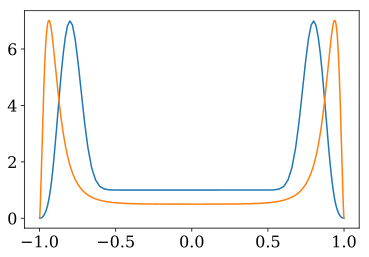

In [20]:
f = (1+6*np.exp(-np.power((0.8-np.abs(z))*10,2)))
# f = np.tanh(np.power(1-np.abs(z)*10,2))
f *= np.tanh(((1-np.abs(z))*10)**2)
plt.plot(z,f)
eta = 1 - np.abs(z)
g = 0.5*np.power(200*eta,3/(1+np.exp(10*eta)))
plt.plot(z,g)

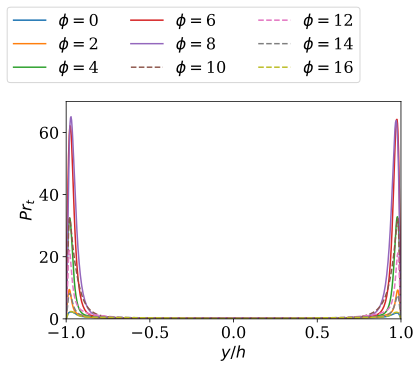

In [21]:
for iphase in range(number_of_phases//4+1):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[2*iphase,i,:]
    k /= 2.
    nu_t = 0.09*k**2/stats[2*iphase,i_eps,:]
    alpha_t = -stats[2*iphase,i_wT,:]/stats[2*iphase,i_dTdy,:]
    Prt = nu_t/alpha_t
    if iphase <= number_of_phases //8:
        plt.plot(z,Prt, '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,Prt, '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
plt.ylim(0,70)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$Pr_t$")
plt.savefig("Prt_k-e.pdf", bbox_inches="tight")
plt.show()

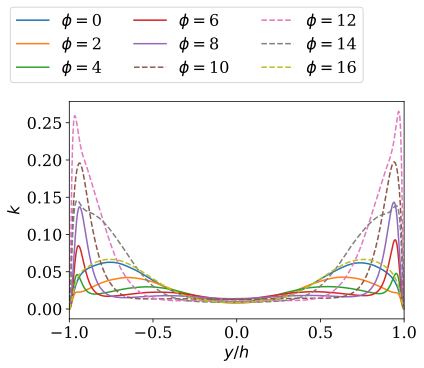

In [22]:
for iphase in range(number_of_phases//4+1):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[2*iphase,i,:]
    k /= 2.

    if iphase <= number_of_phases //8:
        plt.plot(z,k, '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,k, '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
# plt.ylim(0,70)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$k$")
plt.savefig("Stat-k.pdf", bbox_inches="tight")
plt.show()

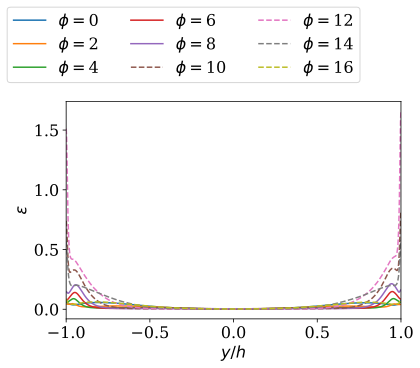

In [23]:
for iphase in range(number_of_phases//4+1):
    
    if iphase <= number_of_phases //8:
        plt.plot(z,stats[2*iphase, i_eps,:], '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,stats[2*iphase, i_eps,:], '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(-1,1)
# plt.ylim(0,70)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$\varepsilon$")
plt.savefig("Stat-eps.pdf", bbox_inches="tight")
plt.show()

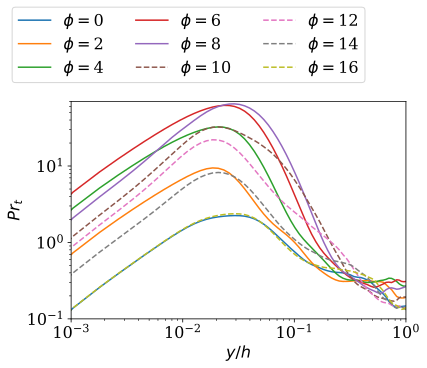

In [24]:
for iphase in range(number_of_phases//4+1):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[2*iphase,i,:]
    k /= 2.
    nu_t = 0.09*k**2/stats[2*iphase,i_eps,:]
    alpha_t = -stats[2*iphase,i_wT,:]/stats[2*iphase,i_dTdy,:]
    Prt = nu_t/alpha_t
    if iphase <= number_of_phases //8:
        plt.loglog(1+z,Prt, '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.loglog(1+z,Prt, '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
plt.xlim(1e-3,1)
plt.ylim(1e-1,70)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$Pr_t$")
plt.savefig("Prt_k-e_loglog.pdf", bbox_inches="tight")
plt.show()

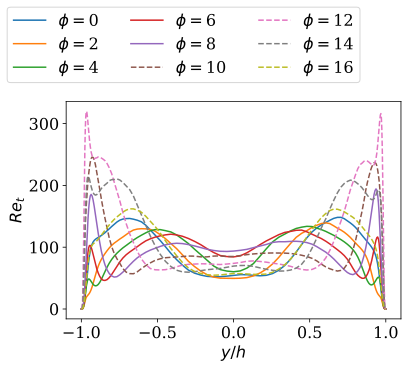

In [25]:
for iphase in range(number_of_phases//4+1):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[2*iphase,i,:]
    k /= 2.
    Ret = k**2/stats[2*iphase,i_eps,:]/nu
    
    if iphase <= number_of_phases //8:
        plt.plot(z,Ret, '-', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    else:
        plt.plot(z,Ret, '--', label = r"$\phi=$"+"{0:.0f}".format(2*iphase))
    
plt.legend(loc=3, bbox_to_anchor=[-0.2, 1.05],
           ncol=3, shadow=False, fancybox=True)
# plt.xlim(0,1)
# plt.ylim(0,70)
plt.xlabel(r"$y/h$")
plt.ylabel(r"$Re_t$")
plt.show()

In [26]:
Prt_base = np.zeros((nz,number_of_phases))
nut_base = np.zeros((nz,number_of_phases))
T_base = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    k = np.zeros(nz)
    for i in [i_uu,i_vv,i_ww]:
        k += stats[iphase,i,:]
    k /= 2.
    nu_t = 0.09*k**2/stats[iphase,i_eps,:]
    alpha_t = -stats[iphase,i_wT,:]/stats[iphase,i_dTdy,:]
    Prt_base[:,iphase] = nu_t/alpha_t
    nut_base[:,iphase] = nu_t
    T_base[:,iphase] = stats[iphase,i_T,:]

In [27]:
from scipy import optimize
Prt_param_f1 = np.zeros((5,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_one = np.copy(Prt_base[:,iphase])
    def cost_function_f_wall(x):
        global z,Prt_base_one
        f = (1+x[0]*np.exp(-np.power((x[1]-np.abs(z))*x[2],2)))
    # f = np.tanh(np.power(1-np.abs(z)*10,2))
        f *= np.tanh(((1-np.abs(z))*x[3]))*x[4]
        return np.linalg.norm(f-Prt_base_one)
    x0 = [10., 0.97, 10., 10.,0.2]
    x_opt = optimize.minimize(cost_function_f_wall,x0, method='Nelder-Mead',
                         options={'maxiter':10000})
    print(iphase,x_opt.nit,x_opt.message,x_opt.x[4])
    Prt_param_f1[:,iphase] = np.copy(x_opt.x)
print(x_opt.x)

0 10000 Maximum number of iterations has been exceeded. 0.274220435342
1 10000 Maximum number of iterations has been exceeded. 0.303950357094
2 910 Optimization terminated successfully. 0.494760438866
3 343 Optimization terminated successfully. 0.0109643410894
4 1049 Optimization terminated successfully. 0.598813693303
5 276 Optimization terminated successfully. 2.76982910516
6 1032 Optimization terminated successfully. 0.303865449617
7 1901 Optimization terminated successfully. 0.854311070124
8 779 Optimization terminated successfully. 0.973149502037
9 817 Optimization terminated successfully. 0.673972151909
10 1154 Optimization terminated successfully. 0.603206312704
11 1154 Optimization terminated successfully. 0.668145931633
12 1495 Optimization terminated successfully. 1.03869778017
13 982 Optimization terminated successfully. 0.726157602108
14 663 Optimization terminated successfully. 0.515773435341
15 717 Optimization terminated successfully. 0.390146922817
16 10000 Maximum numb

In [28]:
from scipy import optimize
Prt_param_g = np.zeros((5,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_one = np.copy(Prt_base[:,iphase])
    def cost_function_f_wall(x):
        global z,Prt_base_one
        g = x[0]*np.power(x[1]*eta,x[2]/(1+np.exp(x[3]*eta))) + 0.01

        return np.linalg.norm(g-Prt_base_one)
    x0 = [0.5, 100, 3, 10, 0.9]
    x_opt = optimize.minimize(cost_function_f_wall,x0, method='Nelder-Mead',
                         options={'maxiter':10000})
    print(iphase,x_opt.nit,x_opt.message,x_opt.x)
    Prt_param_g[:,iphase] = np.copy(x_opt.x)
print(x_opt.x)

0 261 Optimization terminated successfully. [  2.70570577e-01   5.67744846e+02   2.06633794e+00   2.08195957e+01
  -1.94776519e-01]
1 420 Optimization terminated successfully. [  3.55013086e-01   7.51906876e+02   2.31920564e+00   2.99275821e+01
  -5.80885583e+01]
2 423 Optimization terminated successfully. [  3.57906224e-01   1.05214395e+03   3.00299910e+00   3.07526331e+01
  -1.20810101e+01]
3 585 Optimization terminated successfully. [  2.37022231e-01   2.76744252e+03   2.83464408e+00   2.33720458e+01
  -1.10235734e+01]
4 2194 Optimization terminated successfully. [  2.90160368e-02   2.15422262e+04   2.71758514e+00   1.50230178e+01
  -6.99096190e+01]
5 1644 Optimization terminated successfully. [  7.23441659e-03   8.50789732e+04   2.67852241e+00   1.16408746e+01
  -1.09058267e+03]
6 7001 Optimization terminated successfully. [  2.76900886e-04   8.97533551e+05   2.73994645e+00   8.22799581e+00
  -1.05880727e+03]
7 4171 Optimization terminated successfully. [  4.41025135e-03   7.734210

In [22]:
from scipy import optimize
Prt_param_h = np.zeros((2,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_one = np.copy(Prt_base[:,iphase])
    k_base_one = np.copy(k_base[:,iphase])
    dTdy_one = np.copy(stats[iphase,i_dTdy,:])
    def cost_function_h(x):
        global z,Prt_base_one, k_base_one
        h = np.power(k_base_one,x[0])*np.power(1-dTdy_one,x[1])

        return np.linalg.norm(h-Prt_base_one)
    x0 = [0.5, 2.]
    x_opt = optimize.minimize(cost_function_h,x0, method='Nelder-Mead',
                         options={'maxiter':10000})
    print(iphase,x_opt.nit,x_opt.message,x_opt.x)
    Prt_param_h[:,iphase] = np.copy(x_opt.x)
print(x_opt.x)

0 41 Optimization terminated successfully. [0.45108175 1.48916849]
1 34 Optimization terminated successfully. [0.45262693 1.9023915 ]
2 37 Optimization terminated successfully. [0.38931041 2.33159616]
3 33 Optimization terminated successfully. [0.31335806 2.61559723]
4 40 Optimization terminated successfully. [0.28963449 2.93274239]
5 44 Optimization terminated successfully. [0.28544611 3.23724405]
6 39 Optimization terminated successfully. [0.30552885 3.50175776]
7 47 Optimization terminated successfully. [0.35780935 3.72666061]
8 46 Optimization terminated successfully. [0.47106164 3.87792256]
9 51 Optimization terminated successfully. [0.57288574 3.70286743]
10 43 Optimization terminated successfully. [0.7606184  3.54438241]
11 45 Optimization terminated successfully. [1.08313513 3.49640735]
12 44 Optimization terminated successfully. [1.29802254 3.29338316]
13 42 Optimization terminated successfully. [1.21341442 2.97399564]
14 40 Optimization terminated successfully. [0.97041049 2.

(129, 32)
[27.37054426  0.99799833 28.62846915 57.40682989  0.49476044]
[ 3.57906224e-01  1.05214395e+03  3.00299910e+00  3.07526331e+01
 -1.20810101e+01]


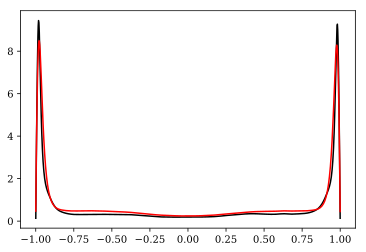

In [23]:
print(k_base.shape)
def f_wall(x):
    global z,Prt_base_one
    f = (1+x[0]*np.exp(-np.power((x[1]-np.abs(z))*x[2],2)))
# f = np.tanh(np.power(1-np.abs(z)*10,2))
    f *= np.tanh(((1-np.abs(z))*x[3]))*x[4]
    return f

def g_wall(x):
    g = x[0]*np.power(x[1]*eta,x[2]/(1+np.exp(x[3]*eta)))
    return g
def h_wall(x,iphase):
    global k_base
    h = np.power(k_base[:,iphase],x[0])*np.power(1- stats[iphase,i_dTdy,:] ,x[1])
    return h
iphase = 2
f_opt = f_wall(Prt_param_f1[:,iphase])
g_opt = g_wall(Prt_param_g[:,iphase])
h_opt = h_wall(Prt_param_h[:,iphase],iphase)
print(Prt_param_f1[:,iphase])
print(Prt_param_g[:,iphase])
plt.plot(z,Prt_base[:,iphase], 'k')
# plt.plot(z,f_opt, 'C0')
# plt.plot(z,g_opt, 'C1')
plt.plot(z,h_opt, 'r')
# i = 3
# print(Prt_param_f1[i,:])

# plt.plot(Prt_param_f1[i,:], label = "{0:.0f}.format(i)")

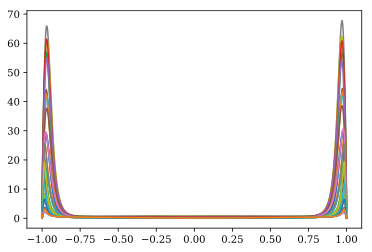

In [24]:
Prt_base_h = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_h[:,iphase] = h_wall(Prt_param_h[:,iphase],iphase)
    plt.plot(z,Prt_base_h[:,iphase])

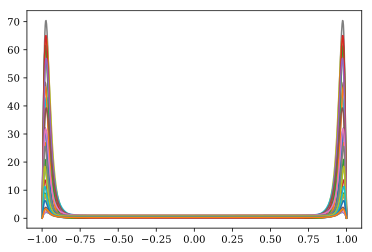

In [25]:
Prt_base_g = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_g[:,iphase] = g_wall(Prt_param_g[:,iphase])
    plt.plot(z,Prt_base_g[:,iphase])

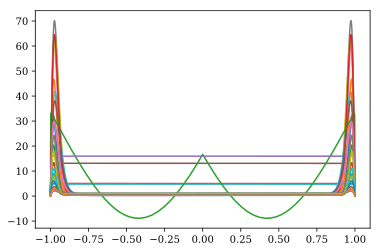

In [26]:
Prt_base_f = np.zeros((nz,number_of_phases))
for iphase in range(number_of_phases):
    Prt_base_f[:,iphase] = f_wall(Prt_param_f1[:,iphase])
    plt.plot(z,Prt_base_f[:,iphase])

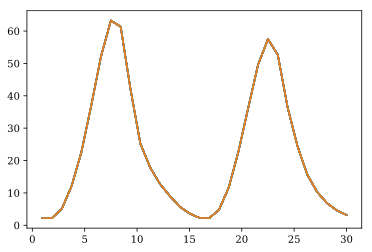

In [27]:
Tperiod = 30.
t = np.zeros(number_of_phases)
for iphase in range(number_of_phases):
    t[iphase] = (iphase+1)*Tperiod/number_of_phases
k = 20 
for iphase in range(number_of_phases):
    plt.plot(t,Prt_base[k,:])
#     plt.plot(z,Prt_base[:,iphase],'-')
#     print(Prt_base[k,iphase],'-')


In [28]:
import scipy.interpolate as scinterp
Nt = 4096
dt = Tperiod / Nt
print(Nt)
tsim = np.linspace(0,Tperiod,Nt+1)
tper = np.zeros(number_of_phases+1)
Prt_base_per = np.zeros((nz,number_of_phases+1))
Prt_base_h_per = np.zeros((nz,number_of_phases+1))
Prt_base_g_per = np.zeros((nz,number_of_phases+1))
Prt_base_f_per = np.zeros((nz,number_of_phases+1))
nut_base_per = np.zeros((nz,number_of_phases+1))
T_base_per = np.zeros((nz,number_of_phases+1))
tper[1:] = np.copy(t)
Prt_base_per[:,1:] = np.copy(Prt_base)
Prt_base_per[:,0] = np.copy(Prt_base[:,-1])
Prt_base_h_per[:,1:] = np.copy(Prt_base_h)
Prt_base_h_per[:,0] = np.copy(Prt_base_h[:,-1])
Prt_base_g_per[:,1:] = np.copy(Prt_base_g)
Prt_base_g_per[:,0] = np.copy(Prt_base_g[:,-1])
Prt_base_f_per[:,1:] = np.copy(Prt_base_g)
Prt_base_f_per[:,0] = np.copy(Prt_base_g[:,-1])
nut_base_per[:,1:] = np.copy(nut_base)
nut_base_per[:,0] = np.copy(nut_base[:,-1])
T_base_per[:,1:] = np.copy(T_base)
T_base_per[:,0] = np.copy(T_base[:,-1])
Prt_sim = np.zeros((nz,Nt+1))
Prt_model_g = np.zeros((nz,Nt+1))
Prt_model_h = np.zeros((nz,Nt+1))
nut_sim = np.zeros((nz,Nt+1))
T_sim = np.zeros((nz,Nt+1))
for k in range(nz):
    fPrt = scinterp.CubicSpline(tper,Prt_base_per[k,:],bc_type='periodic')
    Prt_sim[k,:] = fPrt(tsim)
    fPrt_g = scinterp.CubicSpline(tper,Prt_base_g_per[k,:],bc_type='periodic')
    Prt_model_g[k,:] = fPrt_g(tsim)
    fPrt_h = scinterp.CubicSpline(tper,Prt_base_h_per[k,:],bc_type='periodic')
    Prt_model_h[k,:] = fPrt_h(tsim)
    fPrt_g = scinterp.CubicSpline(tper,Prt_base_g_per[k,:],bc_type='periodic')
    Prt_model_g[k,:] = fPrt_g(tsim)
    fnut = scinterp.CubicSpline(tper,nut_base_per[k,:],bc_type='periodic')
    nut_sim[k,:] = fnut(tsim)
    fT = scinterp.CubicSpline(tper,T_base_per[k,:],bc_type='periodic')
    T_sim[k,:] = fT(tsim)
    


4096


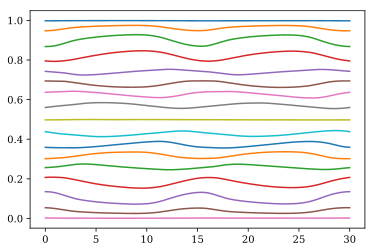

In [29]:
for k in range(0,nz,8):
    plt.plot(tsim,T_sim[k,:])

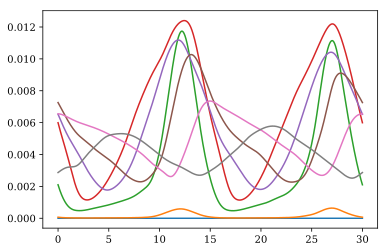

In [30]:
for k in range(0,nz//2,8):
    plt.plot(tsim,nut_sim[k,:])

In [31]:
def diffusion_matrix_coefficients(alpha):
    """ arguments must be from bottom wall to top wall of dimensions N+2
        returns a,b,c of dimensions N (from first to last points off the walls)"""
    global dt_2, a_metrics, c_metrics
    n = len(alpha)
    a = np.zeros(n-2)
    b = np.zeros(n-2)
    c = np.zeros(n-2)
    a[:] = (alpha[0:-2] + alpha[1:-1])*a_metrics[:]
    c[:] = (alpha[2:] + alpha[1:-1])*c_metrics[:]
    b = -(a+c)
    a *= dt_2
    b *= dt_2
    c *= dt_2
    return a,b,c
def rhs_T(a_rhs,b_rhs,c_rhs,a_lhs,c_lhs,T_old_all):
    global T_lower_wall,T_upper_wall,dt_2,dt
    d = a_rhs*T_old_all[:-2] + (b_rhs + 1)*T_old_all[1:-1] + c_rhs*T_old_all[2:]
    d[0] += a_lhs[0]*T_lower_wall
    d[-1] += c_lhs[-1]*T_upper_wall
    return d

In [32]:
T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def simulation_one_cycle():
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt_sim[:,it+1]
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase

for icycle in range(10):
    T_all, T_sim_phase,wall_heat_flux_phase = simulation_one_cycle()


        

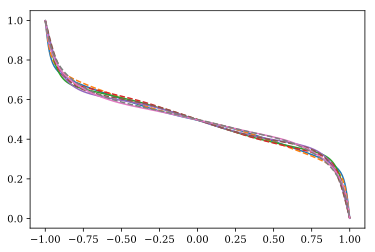

In [33]:
for iphase in range(0,number_of_phases//2,4):
    plt.plot(z,T_sim_phase[:,iphase])
    plt.plot(z,T_base[:,iphase], '--')

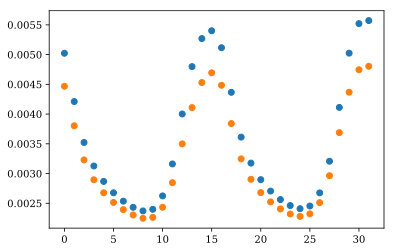

In [34]:
wall_heat_flux_phase_base = np.zeros(number_of_phases)
for iphase in range(number_of_phases):
    T_all[1:-1] = T_base[:,iphase]
    dTdz = dz * T_all
    wall_heat_flux_phase_base[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
plt.plot(wall_heat_flux_phase,'o')
plt.plot(wall_heat_flux_phase_base,'o')
wall_heat_flux_phase_ref = np.copy(wall_heat_flux_phase)
T_sim_phase_ref = np.copy(T_sim_phase)

In [54]:
T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def simulation_one_cycle_cst_Pr(Prt):
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase

for icycle in range(10):
    T_all, T_sim_phase,wall_heat_flux_phase = \
    simulation_one_cycle_cst_Pr(0.9)


        

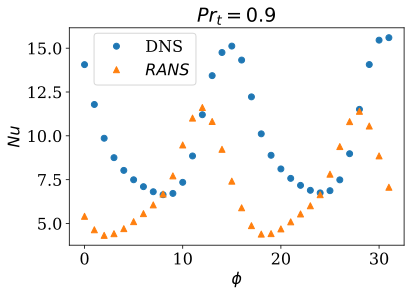

In [63]:
plt.title(r"$Pr_t=0.9$")
plt.xlabel(r"$\phi$", fontdict= fontlabel)
plt.ylabel(r"$Nu$", fontdict= fontlabel)
plt.plot(2*wall_heat_flux_phase_ref/alpha,'o', label = r"DNS")
plt.plot(2*wall_heat_flux_phase/alpha,'^', label = r"$RANS$")
plt.legend(loc=3, bbox_to_anchor=[0.05, 0.7],
           ncol=1, shadow=False, fancybox=True)
plt.savefig("Nu_cst_Prt_0.9.png", bbox_inches="tight")
plt.show()

In [64]:

T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def cost_function(x): 
    icycle = 0
    error_L2 = np.inf
    ncycles_max = 15
    error_wall_heat_flux = np.zeros(ncycles_max)
    wall_heat_flux_phase = np.zeros(number_of_phases)
    while (icycle < ncycles_max) and (error_L2 > 1e-3):
        
        
        if icycle > 0:
            wall_heat_flux_phase_old = np.copy(wall_heat_flux_phase)
        T_all, T_sim_phase,wall_heat_flux_phase = \
        sim_one_cycle_Prt_phase(x)
        if icycle > 0:
            error = wall_heat_flux_phase_old-wall_heat_flux_phase
            error /= wall_heat_flux_phase
            error_L2 = np.linalg.norm(error,2)
            error_wall_heat_flux[icycle-1] = error_L2
        icycle += 1
    print(icycle,error_L2)
    print(x)
    error = wall_heat_flux_phase_ref-wall_heat_flux_phase
    error /= wall_heat_flux_phase
    error_L2 = np.linalg.norm(error,2)
    print(error_L2)
    clear_output(wait=True)
    return error_L2
def sim_one_cycle_Prt_phase(x):
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz, number_of_phases
    x_per = np.zeros(number_of_phases+1)
    x_per[1:] = np.copy(x)
    x_per[0] = x[-1]
    fPrt = scinterp.CubicSpline(tper,x_per,bc_type='periodic')
    Prt_opt = fPrt(tsim)
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt_opt[it+1]
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase
# x = 0.9*np.ones(number_of_phases)
# wall_heat_flux_phase_old = np.copy(wall_heat_flux_phase)
# number_of_cycles = 10
# error_wall_heat_flux = np.zeros(number_of_cycles-1)
# for icycle in range(number_of_cycles):
#     wall_heat_flux_phase_old = np.copy(wall_heat_flux_phase)
#     T_all, T_sim_phase,wall_heat_flux_phase = \
#     sim_one_cycle_Prt_phase(x)
#     if icycle > 0:
#         error = wall_heat_flux_phase_old-wall_heat_flux_phase
#         error /= wall_heat_flux_phase
#         error_wall_heat_flux[icycle-1] = \
#         np.linalg.norm(error,2)

# plt.plot(wall_heat_flux_phase_ref,'o')
# plt.plot(wall_heat_flux_phase,'o')
# plt.show()
# plt.semilogy(error_wall_heat_flux)
# plt.show()

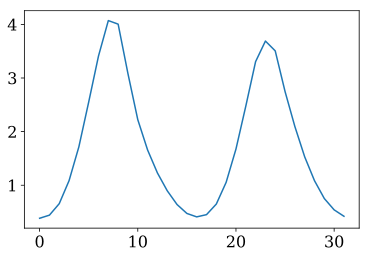

In [65]:
Prt_mean_base = np.zeros(number_of_phases)
for iphase in range(number_of_phases):
    Prt_mean_base[iphase] = np.trapz(Prt_base[:,iphase], z)/2.
plt.plot(Prt_mean_base)

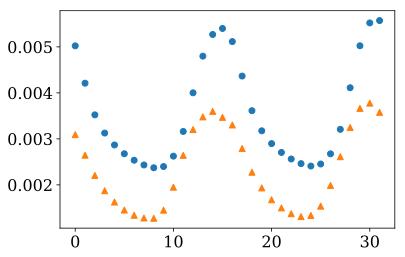

In [66]:
from scipy import optimize
T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)

# x = 0.9*np.ones(number_of_phases)
        
Prt_opt = optimize.minimize(cost_function,Prt_mean_base,
                            method='Nelder-Mead',
                            options = {'maxiter':100, 'xatol':1e-2})

# Prt_opt = optimize.minimize(cost_function,Prt_mean_base,
#                             method='Nelder-Mead',
#                             options = {'maxiter':20, 'xatol':1e-2})

plt.plot(wall_heat_flux_phase_ref,'o')
plt.plot(wall_heat_flux_phase,'^')
plt.show()




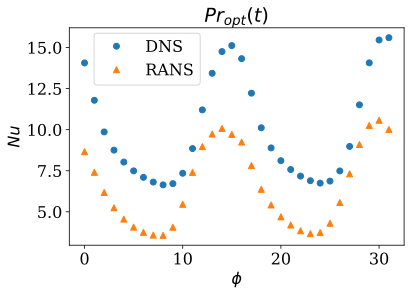

In [71]:
# np.save(Prt_opt)
plt.title(r"$Pr_{opt}(t)$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$Nu$")
plt.plot(2*wall_heat_flux_phase_ref/alpha,'o', label = r"DNS")
plt.plot(2*wall_heat_flux_phase/alpha,'^', label = r"RANS")
plt.legend(loc=3, bbox_to_anchor=[0.05, 0.7],
           ncol=1, shadow=False, fancybox=True)
# plt.legend(loc=3, bbox_to_anchor=[0.05, 7],
#            ncol=1, shadow=False, fancybox=True)
plt.savefig("Nu_var_t_Prt.png", bbox_inches="tight")
plt.show()

[0.35772179 0.42386613 0.6442334  1.08233462 1.73283065 2.58985887
 3.48065331 4.14182937 4.3371169  3.1602529  2.30909522 1.77242334
 1.28368402 0.92532321 0.64408373 0.4605946  0.33260206 0.42998792
 0.63173484 1.03575865 1.68601269 2.50453869 3.36465502 3.77355089
 3.58035933 2.82833612 2.17442466 1.46930401 1.12917944 0.76265103
 0.54087646 0.41125071]


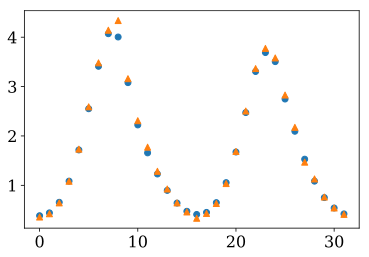

100 Maximum number of iterations has been exceeded.


In [69]:
print(Prt_opt.x)
plt.plot(Prt_mean_base,'o')
plt.plot(Prt_opt.x,'^')
plt.show()
Prt_opt_save = np.copy(Prt_opt.x)
print(Prt_opt.nit, Prt_opt.message)

$$
\frac{\overline{T}_{j}-\overline{T}_{j-1}}{2(\Delta y)^2}{\alpha_T}_{j-1}-
\frac{\overline{T}_{j-1}-2\overline{T}_{j}+\overline{T}_{j+1}}{2(\Delta y)^2}{\alpha_T}_{j}-
\frac{\overline{T}_{j+1}-\overline{T}_{j}}{(2\Delta y)^2}{\alpha_T}_{j+1}=  \alpha\frac{\overline{T}_{j-1}^+-2\overline{T}_{j}+\overline{T}_{j+1}}{(\Delta y)^2}\,,
$$
which is readily in a tridiagonal matrix form:
$$
A_{i\,j}n_{j}=b_i
$$
with
\begin{eqnarray}
&A_{i\,j-1}&= \frac{\overline{u}_{j}^+-\overline{u}_{j-1}^+}{2(\Delta y^+)^2}\,,\\
&A_{i\,j}&= -\frac{\overline{u}_{j-1}^+-2\overline{u}_{j}^++\overline{u}_{j+1}^+}{2(\Delta y^+)^2}\,,\\
&A_{i\,j+1}&= -\frac{\overline{u}_{j+1}^+-\overline{u}_{j}^+}{(2\Delta y^+)^2}\,,\\
&b_i&= \frac{1}{h^+} + \frac{\overline{u}_{j-1}^+-2\overline{u}_{j}^++\overline{u}_{j+1}^+}{(\Delta y^+)^2}\,.
\end{eqnarray}

In [72]:
# T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def simulation_one_cycle_var_tz_Pr(Prt):
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt[:,it+1]
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase

Prt_mean_opt = 1.2*np.ones((nz,Nt+1))
# for k in range(nz):
#     Prt_mean_opt[k,:] *= Prt_opt[:]
for icycle in range(20):
    print(icycle)
    if icycle < 10:
        Prt_mix = max((10 - icycle)/10,0)*Prt_mean_opt + min(icycle/10.,1.) * Prt_model_g
    T_all, T_sim_phase,wall_heat_flux_phase = \
    simulation_one_cycle_var_tz_Pr(Prt_mix)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


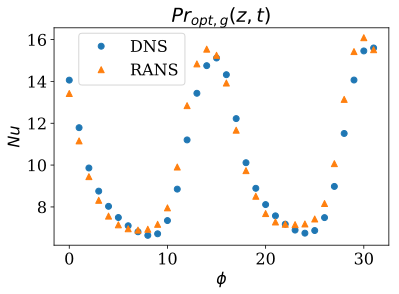

In [73]:
plt.title(r"$Pr_{opt,g}(z,t)$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$Nu$")
plt.plot(2*wall_heat_flux_phase_ref/alpha,'o', label = r"DNS")
plt.plot(2*wall_heat_flux_phase/alpha,'^', label = r"RANS")
plt.legend(loc=3, bbox_to_anchor=[0.05, 0.7],
           ncol=1, shadow=False, fancybox=True)
plt.savefig("Nu_var_tz_Prt_g.png", bbox_inches="tight")
plt.show()

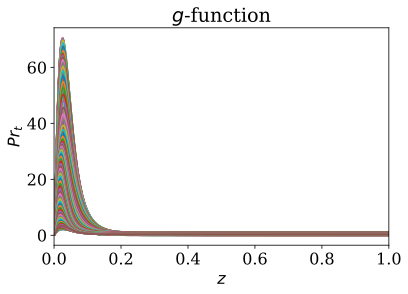

In [86]:
plt.title(r"$g$-function")
plt.xlabel(r"$z$")
plt.ylabel(r"$Pr_t$")
for k in range(0,Nt,16):
    plt.plot(1+z[1:],Prt_model_g[1:,k])
plt.xlim(0,1)
plt.savefig("Prt_g.png", bbox_inches="tight")
plt.show()

In [74]:
# T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def simulation_one_cycle_var_tz_Pr(Prt):
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt[:,it+1]
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase


# for icycle in range(5):
#     print(icycle)
#     T_all, T_sim_phase,wall_heat_flux_phase = \
#     simulation_one_cycle_var_tz_Pr(Prt_model_h)

Prt_mean_opt = 1.2*np.ones((nz,Nt+1))
# for k in range(nz):
#     Prt_mean_opt[k,:] *= Prt_opt[:]
for icycle in range(20):
    print(icycle)
    if icycle < 10:
        Prt_mix = max((10 - icycle)/10,0)*Prt_mean_opt + min(icycle/10.,1.) * Prt_model_h
    T_all, T_sim_phase,wall_heat_flux_phase = \
    simulation_one_cycle_var_tz_Pr(Prt_mix)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


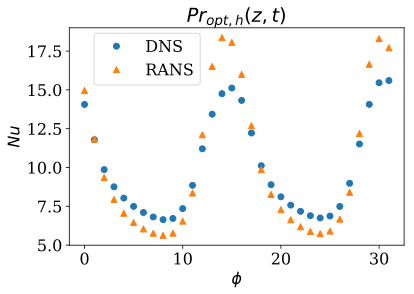

In [88]:
plt.title(r"$Pr_{opt,h}(z,t)$")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$Nu$")
plt.plot(2*wall_heat_flux_phase_ref/alpha,'o', label = r"DNS")
plt.plot(2*wall_heat_flux_phase/alpha,'^', label = r"RANS")
plt.legend(loc=3, bbox_to_anchor=[0.05, 0.7],
           ncol=1, shadow=False, fancybox=True)
# plt.ylim(0,17)
plt.savefig("Nu_var_tz_Prt_h.pdf", bbox_inches="tight")
plt.show()

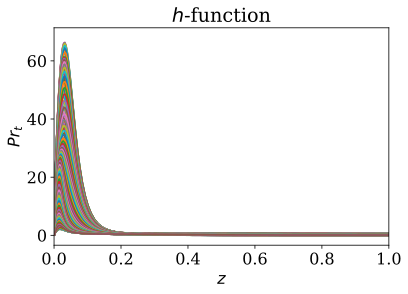

In [85]:
plt.title(r"$h$-function")
plt.xlabel(r"$z$")
plt.ylabel(r"$Pr_t$")
for k in range(0,Nt,16):
    plt.plot(1+z[1:],Prt_model_h[1:,k])
plt.xlim(0,1)
plt.savefig("Prt_h.png", bbox_inches="tight")
plt.show()

In [51]:
# T_lower_wall = 1.
T_upper_wall = 0.

alpha = 1./(2000*0.7)

nit_phase = Nt / number_of_phases

###################
simulation_time = 1*Tperiod #run time
###################
#### Time Step ####
###################
# dt = 0.1*40/32. #see above

##################
# convergence_iteration_max = 5000
# convergence_tolerance = 1e-4
dt_2 = dt/2

h = 1.


max_iterations = int(simulation_time / dt)


z_dist_all = np.copy(z_all)
z_dist_all = h + z_all
mask = np.where(z_all > 0.)
z_dist_all[mask] = h - z_all[mask]

T = np.copy(T_sim[:,0])
T_old = np.zeros(nz)
T_half = np.zeros(nz)
T_all = np.zeros(nz+2)
alpha_total_all = np.ones(nz+2)
alpha_t_all = np.zeros(nz+2)
T_all[0] = T_lower_wall
T_all[-1] = T_upper_wall
T_all[1:-1] = np.copy(T)
T_exact = np.zeros(nz+2)
t = 0
a_rhs = np.zeros(nz)
b_rhs = np.zeros(nz)
c_rhs = np.zeros(nz)
a_lhs = np.zeros(nz)
b_lhs = np.zeros(nz)
c_lhs = np.zeros(nz)
alpha_total_all = np.ones(nz+2)*alpha
alpha_total_all[1:-1] += nut_sim[:,0] / Prt_sim[:,0]
a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
T_sim_phase = np.zeros((nz,number_of_phases))
wall_heat_flux_phase = np.zeros(number_of_phases)
t = 0.
t_save = 0.

def simulation_one_cycle_var_tz_Pr(Prt):
    global a_lhs,b_lhs,c_lhs, nut_sim,Prt_sim, alpha, dz
    it_phase = 1
    iphase = 0
    for it in range(Nt):

        a_rhs = np.copy(a_lhs)
        b_rhs = np.copy(b_lhs)
        c_rhs = np.copy(c_lhs)

        T_old = np.copy(T_all[1:-1])
        alpha_total_all = np.ones(nz+2)*alpha
        alpha_total_all[1:-1] += nut_sim[:,it+1] / Prt[:,it+1]
        a_lhs, b_lhs, c_lhs = diffusion_matrix_coefficients(alpha_total_all)
        d = rhs_T(a_rhs, b_rhs, c_rhs, a_lhs, c_lhs, T_all)
    #     print(d)
        T_all[1:-1] = TDMAsolver(-a_lhs, 1-b_lhs , -c_lhs, d)

        if it_phase == nit_phase -1:
            T_sim_phase[:,iphase] = T_all[1:-1]
            dTdz = dz*T_all
            wall_heat_flux_phase[iphase] = -alpha*(dTdz[0] + dTdz[-1])/2.
            it_phase =0
            iphase += 1

        it_phase += 1
    return T_all, T_sim_phase,wall_heat_flux_phase

Prt_mean_opt = 1.2*np.ones((nz,Nt+1))
# for k in range(nz):
#     Prt_mean_opt[k,:] *= Prt_opt[:]
for icycle in range(20):
    print(icycle)
    if icycle < 10:
        Prt_mix = max((10 - icycle)/10,0)*Prt_mean_opt 
        + min(icycle/10.,1.) * Prt_model_g
#     T_all, T_sim_phase,wall_heat_flux_phase = \
#     simulation_one_cycle_var_tz_Pr(Prt_mix)
    T_all, T_sim_phase,wall_heat_flux_phase = \
    simulation_one_cycle_var_tz_Pr(0.9*np.ones((nz,Nt+1)))




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


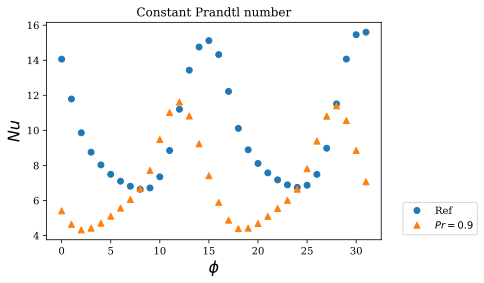

In [53]:
plt.title(r"Constant Prandtl number")
plt.xlabel(r"$\phi$", fontdict= fontlabel)
plt.ylabel(r"$Nu$", fontdict= fontlabel)
plt.plot(2*wall_heat_flux_phase_ref/alpha,'o', label = r"Ref")
plt.plot(2*wall_heat_flux_phase/alpha,'^', label = r"$Pr=0.9$")
plt.legend(loc=3, bbox_to_anchor=[1.05, 0],
           ncol=1, shadow=False, fancybox=True)
plt.savefig("Nu_cst_Prt_0.9.png", bbox_inches="tight")
plt.show()

In [49]:
dyu = 0.1
nu = 1e-6
tauw = nu*dyu
utau = np.sqrt(tauw)
dy = .0013
print(dy*utau/nu)

0.411096095822


In [50]:
print((1+z[0])*2000)

0.670593801383


In [51]:
print((1+z[0])*np.sqrt(nu*np.abs((stats[:,i_dudy,0])))/nu)

[ 2.31501565  2.72957017  2.99566757  3.15777431  3.23461067  3.23821466
  3.17264075  3.04169775  2.8502178   2.61516079  2.39008036  2.20543989
  2.0188713   1.60057969  0.45508789  1.61303311  2.29636804  2.71510757
  2.98351597  3.14769031  3.22737264  3.23309237  3.17195249  3.04569645
  2.8629369   2.64294214  2.41749709  2.28323998  2.14586672  1.7289133
  0.62598284  1.62835909]
